# Chargement des données
On upload notre dataset d'images au format jpg et correctemment nommées, et on le convertit en images et labels au format npy 


In [0]:
from os import listdir
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
import cv2

import keras.backend as K
from keras.models import load_model

Using TensorFlow backend.


In [0]:
!rm *.zip
from google.colab import files
files.upload()


rm: cannot remove '*.zip': No such file or directory


Saving image.zip to image.zip


{u'image.zip': 'PK\x03\x04\n\x00\x00\x00\x00\x00\xf9l\xa7N\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x06\x00\x00\x00image/PK\x03\x04\x14\x00\x00\x00\x08\x007\\\xa7N^\xa7\xa1N\'\x0b\x00\x00\xb6\x0b\x00\x00 \x00\x00\x00image/1557228604.3176749_1_0.jpg\x9d\xd4y4\xd4\xff\x1a\x07\xf0\xef\x18f\x0c#\xd1\x8c,c\x1d\xbb\xc8\x16#\xcbXb\xcc\x14S\xf6\xad\xac\xfdd+\xbb\x8c\x94-I\xd6\xa9A\x92!blY\xa2\x14\x89"{2\x065\x14B\xd6!\x85Bqu\xcf]\xfe\xb9\x7f\xdc{\xdf\x9f?\x9f\xe7|\xce\xf3:\xcf9\xcf\xde\xfb\xbdI\xe0 \xc1\x0co\x06\x80@\x00\x00\xda\x7f\xc0\xde\x18`\x02pB P\x08\x07\'\x14\n\x85\xc18\xb9\xe0\x08\x1e877\\\x88\xff\x10/BTX\\LT\x18\x85\x92\x90V\x91\x93\x90:\x82F\xa1\xe4\xb5\x15\x8e\xa8\xaaijj\x8a\xcb\xe9\xe8c\xd4\xf5T44\xd5\xff|\x02\x82\xc1`pn\xb8 \x0f\x8f\xa0\xba$JR\xfd\x7f\xce^+\xc0\xc7\t\xb8\x01\x05`\x90\x14\xc0\xc6\x07\x02\xf3\x81\xf6\xda\x01\xf1\xfd99@\x7f\x0f\xf0\x8f\x80\xd8\xc0\xec\x1c\x10(\'\x8c\x8b{\xbf\xa1\xe1 \xc0\x06\x02\x83\xd9\xd8\xc1\x1c\x1c\xec\xec\xfb\xd5\xe8\xfd:\xc0\xce\xc7\xc1

In [0]:
!unzip image.zip

In [0]:
dataset = "image"  #A remplacer par le nom du dossier contenant les images

In [0]:
def load_photos(directory):
    '''
    Loads the photo from the directory and return arrays of images and labels
    '''
    images = []
    directions = []
    vitesses = []
    dir_list = listdir(directory)
    random.shuffle(dir_list)
    for name in dir_list:
        filename = directory + '/' + name
        image = load_img(filename, target_size=(96, 160))
        image = img_to_array(image)
        images.append(image)
        direction = float((name.split('_')[2]).split('.jpg')[0])
        directions.append(direction)
        vitesse = float(name.split('_')[1])
        vitesses.append(vitesse)
    return images, directions, vitesses

In [0]:
X, Y, Z = load_photos(dataset)
print'Images chargées pour entraînement :',len(X)

Images chargées pour entraînement : 847


In [0]:
#Normalise images
X = np.array(X)
X /= 255.0

In [0]:
#convert datas to arrays 
Y = np.array(pd.get_dummies(Y)) #-1 -> [1,0,0] left ; 0 -> [0,1,0] straight ; 1 -> [0,0,1] right
Z = np.array(pd.get_dummies(Z))

In [0]:
!ls



image  image.zip  sample_data


# Augmentation des données

On augmente notre jeu de données à l'aide de fonction(s)

In [0]:
def mirror_image(X,Y):
    '''
    Do a horizontal flip on every images of the dataset
    '''
    X_mirror = []
    Y_mirror = []
    i=0
  
    for image in X:
        image = cv2.flip(image, 1)# 1 correspond to horizontal
        X_mirror.append(image)
        Y_mirror.append(np.flip(Y[i]))
        i=i+1
    return X_mirror,Y_mirror


In [0]:
def random_shadow(image):
    """
    Generates and adds random shadow
    """
    # (x1, y1) and (x2, y2) forms a line
    # xm, ym gives all the locations of the image
    x1, y1 = 160 * np.random.rand(), 0
    x2, y2 = 160 * np.random.rand(), 96
    xm, ym = np.mgrid[0:96, 0:160]

    # mathematically speaking, we want to set 1 below the line and zero otherwise
    # Our coordinate is up side down.  So, the above the line: 
    # (ym-y1)/(xm-x1) > (y2-y1)/(x2-x1)
    # as x2 == x1 causes zero-division problem, we'll write it in the below form:
    # (ym-y1)*(x2-x1) - (y2-y1)*(xm-x1) > 0
    mask = np.zeros_like(image[:, :, 1])
    mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1

    # choose which side should have shadow and adjust saturation
    cond = mask == np.random.randint(2)
    s_ratio = np.random.uniform(low=0.2, high=0.5)

    # adjust Saturation in HLS(Hue, Light, Saturation)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
    shadowed = cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)
    return shadowed
  


In [0]:
def random_brightness(X,Y):
    X_bright = []
    Y_bright = []
    i=0
    
    for image in X:
        # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        ratio = 1 + 0.8 * (np.random.rand() - 0.5)
        hsv[:,:,2] =  hsv[:,:,2] * ratio
        tmp = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
        X_bright.append(tmp)
        Y_bright.append(Y[i])
        i=i+1
    return X_bright, Y_bright


In [0]:
#Here we augment the data with the previously declared functions, you should adapt if you don't want to use all the augmentation functions
X_bright, Y_bright = random_brightness(X, Y)
X_tmp = np.concatenate((X, X_bright))
Y_tmp = np.concatenate((Y, Y_bright))


X_mirror, Y_mirror = mirror_image(X_tmp,Y_tmp)
X_final = np.concatenate((X_tmp, X_mirror))
Y_final = np.concatenate((Y_tmp, Y_mirror))
  


print'Le dataset est desormais composé de', len(Y_final),'images'

Le dataset est desormais composé de 3388 images


# Visualisation des données
***Optionnel***

C'est ici qu'on peut visualiser notre dataset

(array([0, 1, 0], dtype=uint8), <matplotlib.image.AxesImage at 0x7f62de6e2190>)

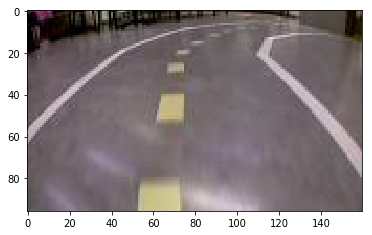

In [0]:
index_test = 500
Y_final[index_test], plt.imshow(X_final[index_test])

(array([0, 1, 0], dtype=uint8), <matplotlib.image.AxesImage at 0x7f62dfe76dd0>)

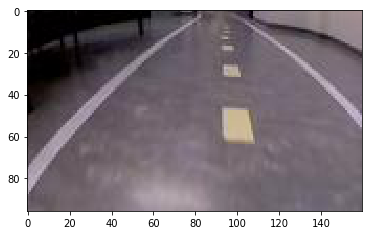

In [0]:
index_test_2 = 11
Y[index_test_2], plt.imshow(X[index_test_2])

In [0]:
def label_decoder(tab): #return the original label's value 
    if np.array_equal(tab, [1,0,0]):
        return -1
    elif np.array_equal(tab, [0,1,0]):
        return 0
    elif np.array_equal(tab, [0,0,1]):#test
        return 1
    else:
        print('Unknown label')
        return
      

Text(0.5,1,'Data distribution')

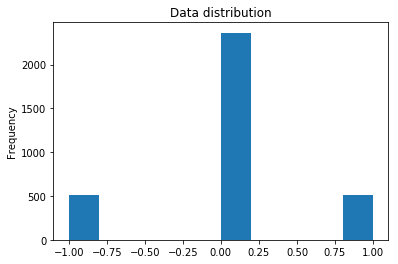

In [0]:
df = pd.DataFrame(Y_final)
df['direction'] = df.apply(label_decoder, axis=1)
df.direction.plot.hist()
plt.title('Data distribution')

# Entraînement du modèle
C'est dans cette section qu'on définie et entraîne le réseau de neuronnes avec notre jeu de données

In [0]:
from keras.models import Model, Sequential
from keras.layers import *
import keras.backend as K
import keras.optimizers as Optimizers
import keras.callbacks

## Choix de l'architecture du réseau de neuronnes
(ne lancer qu'un seul des 2 codes)

**Architecture du réseau  n°1**

Apparemment moins performant mais entraînement plus rapide

In [0]:
K.clear_session()
############################################################# 

img_in = Input(shape=(96, 160, 3), name='img_in')
x = img_in

x = Convolution2D(2, (5,5), strides=(2,2), use_bias=False)(x)       
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Convolution2D(4, (5,5), strides=(2,2), use_bias=False)(x)       
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(.4)(x)
x = Convolution2D(8, (5,5), strides=(2,2), use_bias=False)(x)       
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(.5)(x)

x = Flatten(name='flattened')(x)

x = Dense(100, use_bias=False)(x) 
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(.4)(x)
x = Dense(50, use_bias=False)(x)  
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(.3)(x)

# Multitask Output

#out_speed = Dense(2, activation='softmax')(x)

out_dir = Dense(3, activation='softmax')(x)


# Compile Model
model = Model(inputs=[img_in], outputs=[out_dir])
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          (None, 96, 160, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 78, 2)         150       
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 78, 2)         8         
_________________________________________________________________
activation_1 (Activation)    (None, 46, 78, 2)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 37, 4)         200       
_________________________________________________________________
batch_normalization_2

**Architecture du réseau n°2**

Apparemment plus performant mais l'entraînement est plus long

In [0]:
K.clear_session()

img_in = Input(shape=(96,160,3), name='img_in')                      # First layer, input layer, Shape comes from camera.py resolution, RGB
x = img_in
x = Conv2D(24, 5,5, subsample=(2,2), activation='relu')(x)       # 24 features, 5 pixel x 5 pixel kernel (convolution, feauture) window, 2wx2h stride, relu activation
x = Conv2D(32, 5,5, subsample=(2,2), activation='relu')(x)       # 32 features, 5px5p kernel window, 2wx2h stride, relu activatiion
x = Conv2D(64, 5,5, subsample=(2,2), activation='relu')(x)       # 64 features, 5px5p kernal window, 2wx2h stride, relu
x = Conv2D(64, 3,3, subsample=(1,1), activation='relu')(x)       # 64 features, 3px3p kernal window, 2wx2h stride, relu
x = Conv2D(64, 3,3, subsample=(1,1), activation='relu')(x)       # 64 features, 3px3p kernal window, 1wx1h stride, relu

    # Possibly add MaxPooling (will make it less sensitive to position in image).  Camera angle fixed, so may not to be needed

x = Flatten(name='flattened')(x)                                        # Flatten to 1D (Fully connected)
x = Dense(100, activation='relu')(x)                                    # Classify the data into 100 features, make all negatives 0
x = Dropout(0.1)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
x = Dense(50, activation='relu')(x)                                     # Classify the data into 50 features, make all negatives 0
x = Dropout(0.1)(x)                                                      # Randomly drop out 10% of the neurons (Prevent overfitting)
    
    #categorical output of the angle
angle_out = Dense(3, activation='softmax', name='angle_out')(x)        # Connect every input with every output and output 15 hidden units. Use Softmax to give percentage. 15 categories and find best one based off percentage 0.0-1.0
    
model = Model(input=[img_in], output=[angle_out])
    
model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

model.summary()

## Entraînement et résultats


In [0]:
model_name="exam.h5"

In [0]:
#save best model if model improved
best_checkpoint = keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [0]:
#Train model
try:
    h = model.fit(X_final, Y_final, batch_size=64, epochs=50, validation_split=0.2, verbose=1, callbacks=[best_checkpoint])
except NameError:
    print'Augmented data have not been found, original data will be used' 
    h = model.fit(X, Y, batch_size=64, epochs=50, validation_split=0.2, verbose=1, callbacks=[best_checkpoint])

Train on 2710 samples, validate on 678 samples
Epoch 1/50
2710/2710 [==============================] - 16s 6ms/step - loss: 0.2139 - acc: 0.9162 - val_loss: 0.1892 - val_acc: 0.9145

Epoch 00001: val_loss did not improve from 0.17419
Epoch 2/50
2710/2710 [==============================] - 16s 6ms/step - loss: 0.2001 - acc: 0.9162 - val_loss: 0.1726 - val_acc: 0.9218

Epoch 00002: val_loss improved from 0.17419 to 0.17262, saving model to exam.h5
Epoch 3/50
1600/2710 [================>.............] - ETA: 5s - loss: 0.1949 - acc: 0.9213

KeyboardInterrupt: ignored

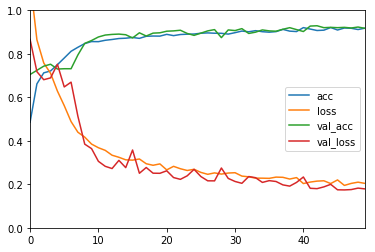

In [0]:
#print History graph
historydf = pd.DataFrame(h.history, index=h.epoch)
historydf.plot(ylim=(0,1))

In [0]:
!ls

image  image.zip  polytest.h5  sample_data


In [0]:
from google.colab import files
files.download('exam.h5')

# Validation du modèle
***Optionnel***

Ici on upload un nouveau jeu d'images avec labels et on vérifie le bon fonctionnement de notre modèle

In [0]:
# Chargement du model
model_name="exam.h5"
model = load_model(model_name)


##Validation sur autre jeu de données (à télécharger)

In [0]:
from google.colab import files
files.upload()

Saving test.zip to test.zip


{u'test.zip': 'PK\x03\x04\x14\x03\x00\x00\x00\x00e\x8c\xa6N\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x05\x00\x00\x00test/PK\x03\x04\x14\x03\x00\x00\x08\x00\x15\x8c\xa6N\xe8.\xffF\x0e\x0b\x00\x00\x99\x0b\x00\x00\x1f\x00\x00\x00test/1557156672.5470707_1_0.jpg\x9c\xd1IL\x13a\x14\x07\xf0\xef\xeb\xcctf\xda\xa90P\x10\x9a\x01\xbaa)\xa9\xc4N\x8b-\x064\x05\xa9\xb4\x07"\x08\x8a\xc6\x03\xad\x1b\xc5hRDA\r\x07\xaa\xe2\x12C\x82KU\xe2A\x04\xb4\x92\xb8  Bb"\x08.\xdcp\x03k4"*\xdaDS\xa4".\xa1N\x89\xcb\xc5\x83\xf2\x7f\xc7\xff\xcbK~y\xc1\xe1\xe0\x0b\x10n5[\xcc\x00B\x00 7 \xf8\x14d\x01\x82\xcf\xc7\xf9\x18\x81\xe38I\x12\x02J,\xa2\x84B*6"2L\x1c\'I\x88\x8f\x930\x8cT\x99\xa2\x92\xca5\n\x86I2\xa85\x0b\xb4z\xbd>A\x95\x96ad\xd3Stz6t\x04\x92$I\t\xa9\x18\x91(\x86\x9512\xf6\xbf\x13\xbc\th\x02\x14\x833\x08\x94\x03\x1e\r\x11\x1a\x06\xfb@\x02\x00\x10\x833\x01?\x03y\x08\x8a\xf1q\x82\x14\x08\xb9\x85\x8ep\xc0\x83\x08\xc2C\x11\x0cCQ\xae\xad\xe2z\x80\xd2X\x84Lk\xe2G\xe6\xd9p\xb9S\xccV\xd75\x10\x8a\xcc\xd6\x9e\xa8\xfc

In [0]:
!unzip test.zip

In [0]:
validation = "test"

In [0]:
X_test, Y_test, Z_test = load_photos(validation)
nb_images2 = len(X_test)
print 'Images chargées pour validation :', nb_images2

Images chargées pour validation : 156


In [0]:
# Normalise les images de test
X_test = np.array(X_test)
X_test /= 255.0

In [0]:
# Obtenir les predictions pour chaque images
predictions = model.predict(X_test)

tab_preds = []
for elem in predictions:
    tab_preds.append(np.argmax(elem))

In [0]:
# Afficher le pourcentage de réussite
correct_pred = 0
droite = 0
gauche = 0
tout_droit = 0
for i, value in enumerate(tab_preds):
   #print(value, Y_test[i])       #Decommeneter cette ligne pour afficher le detail (donnée réelle vs prédiction)
   if(value==0 and Y_test[i] == -1):
        correct_pred += 1
   elif(value==1 and Y_test[i] == 0):
        correct_pred += 1
   elif(value==2 and Y_test[i] == 1):
        correct_pred += 1
   
reussite = float(correct_pred)*100./(float(i)+1.)
print correct_pred,'/',i+1,'correctement predits <=> ',reussite,'% de réussite'
  

142 / 156 correctement predits <=>  91.0256410256 % de réussite


##Validation sur le jeu de données de départ

In [0]:
X_test, Y_test, Z_test = load_photos(dataset)
print'Images chargées pour validation :',len(X_test)

Images chargées pour validation : 847


In [0]:
# Normalise les images de test
X_test = np.array(X_test)
X_test /= 255.0

In [0]:
# Obtenir les predictions pour chaque images
predictions = model.predict(X_test)

tab_preds = []
for elem in predictions:
    tab_preds.append(np.argmax(elem))

In [0]:
# Afficher le pourcentage de réussite directement sur le dataset d'entrainement
correct_pred = 0
for i, value in enumerate(tab_preds):
   #print(value, Y_test[i])       #Decommeneter cette ligne pour afficher le detail (donnée réelle vs prédiction)
   if(value==0 and Y_test[i] == -1):
        correct_pred += 1
   elif(value==1 and Y_test[i] == 0):
        correct_pred += 1
   elif(value==2 and Y_test[i] == 1):
        correct_pred += 1
   
reussite = float(correct_pred)*100./(float(i)+1.)
print correct_pred,'/',i+1,'correctement predits <=> ',reussite,'% de réussite'
  

815 / 847 correctement predits <=>  96.2219598583 % de réussite
